In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [6]:
volume = get_volume()

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([4., 4.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([4., 4.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([4., 4.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([4., 4.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (

# Build dataset

In [8]:
def get_preds(volume:Volume) -> Tensor:
    gen = MuonGenerator2016.from_volume(volume)
    inf = PanelX0Inferer(volume)
    for _ in range(1000//250):
        mus = MuonResampler.resample(gen(250), volume=volume, gen=gen)
        mu = MuonBatch(mus, init_z=volume.h)
        volume(mu)
        sb = PanelScatterBatch(mu, volume)
        inf.add_scatters(sb)
    vox_preds, weights = inf.get_prediction()
    return vox_preds

In [9]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [10]:
pgen = LadleFurnacePassiveGenerator(volume)

In [11]:
preds,targs = [],[]
for i in progress_bar(range(200)):
    f,t = pgen.get_data()
    volume.load_rad_length(f)
    preds.append(get_preds(volume).detach())
    targs.append(t)

/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [12]:
preds = torch.stack(preds)
targs = torch.stack(targs)

In [13]:
preds.shape

torch.Size([200, 10, 10, 10])

In [14]:
with h5py.File('furnace_data_1kmu_1e4_nozero.hdf5', "w") as outfile:
    outfile.create_dataset('preds', data=preds, compression='lzf')
    outfile.create_dataset('targs', data=targs, compression='lzf')

In [11]:
with h5py.File('furnace_data_1kmu_1e4.hdf5', "r") as infile:
    preds = Tensor(infile['preds'][()])
    targs = Tensor(infile['targs'][()])

# Vars

In [12]:
df = pd.DataFrame(targs.numpy(), columns=['gen_target'])

In [13]:
df

,gen_target
0,1.002918
1,1.197800
2,1.161135
3,0.534056
4,1.117202
...,...
195,0.682796
196,1.134742
197,0.394750
198,1.141804


In [155]:
from tomopt.plotting.appearance import *

def plot_pred(pred, targ):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        print("Zero-ordered target layer ID (including ladel bottom layer):", np.floor((targ-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
        plt.show()

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


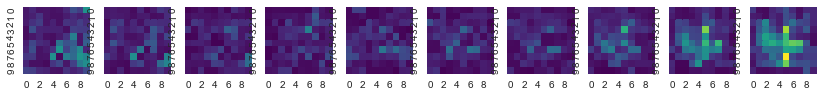

In [156]:
i = 0
plot_pred(preds[i], targs[i])

In [157]:
preds.shape

torch.Size([200, 10, 10, 10])

In [158]:
ladel_removed = preds[:,1:,1:-1,1:-1]

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


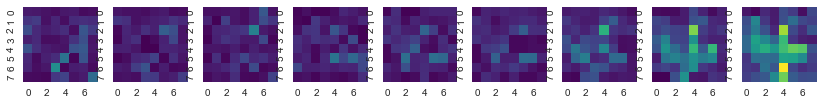

In [159]:
i = 0
plot_pred(ladel_removed[i], targs[i])

# Stat testing

In [18]:
averaged = ladel_removed.mean((-1,-2)); averaged.shape

torch.Size([200, 9])

In [19]:
def get_mse(preds, targs):
    return ((preds-targs)**2).mean()

In [20]:
get_mse((3*volume.passive_size)+volume.get_passive_z_range()[0], targs)

tensor(0.1313)

In [21]:
p = ((averaged.median(1).indices+1)*volume.passive_size)+volume.get_passive_z_range()[0]

In [22]:
p

tensor([0.7000, 0.8000, 0.7000, 1.1000, 0.4000, 0.7000, 0.7000, 0.7000, 0.6000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.5000, 0.7000, 0.7000, 0.8000, 0.7000,
        0.7000, 0.7000, 1.0000, 0.7000, 0.6000, 0.8000, 0.8000, 0.3000, 0.9000,
        0.3000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.5000, 0.3000, 0.7000, 0.8000, 0.7000, 0.5000, 0.7000, 0.3000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.3000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.9000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.8000, 0.4000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.8000, 0.3000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.5000, 0.7000, 0.8000, 0.7000,
        0.7000, 0.7000, 0.6000, 0.6000, 0.7000, 0.7000, 0.7000, 0.8000, 0.7000,
        0.7000, 0.7000, 0.9000, 1.0000, 0.7000, 1.0000, 0.7000, 1.1000, 0.7000,
        0.9000, 0.3000, 0.7000, 0.8000, 0.8000, 0.7000, 1.0000, 0.8000, 0.7000,
        0.7000, 0.3000, 0.7000, 0.3000, 

In [23]:
get_mse(p,targs)

tensor(0.0994)

In [24]:
fs_ratio = pgen.fill_x0s.mean()/pgen.slag_x0s.mean(); fs_ratio

tensor(0.4172)

In [25]:
averaged.shape

torch.Size([200, 9])

In [26]:
maxp = averaged[:,-1]

In [27]:
maxp

tensor([0.0252, 0.0190, 0.0202, 0.0153, 0.0257, 0.0263, 0.0203, 0.0199, 0.0209,
        0.0251, 0.0334, 0.0259, 0.0308, 0.0295, 0.0276, 0.0210, 0.0172, 0.0250,
        0.0301, 0.0181, 0.0197, 0.0241, 0.0301, 0.0314, 0.0216, 0.0241, 0.0236,
        0.0301, 0.0185, 0.0348, 0.0269, 0.0225, 0.0245, 0.0274, 0.0277, 0.0236,
        0.0208, 0.0242, 0.0262, 0.0204, 0.0224, 0.0201, 0.0313, 0.0235, 0.0279,
        0.0264, 0.0210, 0.0199, 0.0207, 0.0317, 0.0302, 0.0276, 0.0266, 0.0272,
        0.0199, 0.0246, 0.0323, 0.0205, 0.0189, 0.0380, 0.0226, 0.0213, 0.0230,
        0.0229, 0.0254, 0.0192, 0.0287, 0.0270, 0.0192, 0.0223, 0.0319, 0.0255,
        0.0222, 0.0167, 0.0260, 0.0241, 0.0260, 0.0230, 0.0325, 0.0234, 0.0336,
        0.0266, 0.0264, 0.0334, 0.0240, 0.0191, 0.0369, 0.0246, 0.0243, 0.0196,
        0.0238, 0.0261, 0.0291, 0.0168, 0.0174, 0.0209, 0.0240, 0.0147, 0.0291,
        0.0195, 0.0270, 0.0221, 0.0236, 0.0221, 0.0279, 0.0211, 0.0225, 0.0204,
        0.0362, 0.0191, 0.0181, 0.0277, 

In [28]:
maxp*fs_ratio

tensor([0.0105, 0.0079, 0.0084, 0.0064, 0.0107, 0.0110, 0.0085, 0.0083, 0.0087,
        0.0105, 0.0139, 0.0108, 0.0129, 0.0123, 0.0115, 0.0087, 0.0072, 0.0104,
        0.0126, 0.0076, 0.0082, 0.0100, 0.0125, 0.0131, 0.0090, 0.0101, 0.0098,
        0.0125, 0.0077, 0.0145, 0.0112, 0.0094, 0.0102, 0.0114, 0.0116, 0.0098,
        0.0087, 0.0101, 0.0109, 0.0085, 0.0093, 0.0084, 0.0131, 0.0098, 0.0116,
        0.0110, 0.0088, 0.0083, 0.0086, 0.0132, 0.0126, 0.0115, 0.0111, 0.0113,
        0.0083, 0.0103, 0.0135, 0.0085, 0.0079, 0.0159, 0.0094, 0.0089, 0.0096,
        0.0096, 0.0106, 0.0080, 0.0120, 0.0113, 0.0080, 0.0093, 0.0133, 0.0106,
        0.0093, 0.0070, 0.0109, 0.0101, 0.0108, 0.0096, 0.0136, 0.0098, 0.0140,
        0.0111, 0.0110, 0.0139, 0.0100, 0.0080, 0.0154, 0.0103, 0.0101, 0.0082,
        0.0099, 0.0109, 0.0122, 0.0070, 0.0073, 0.0087, 0.0100, 0.0061, 0.0121,
        0.0081, 0.0113, 0.0092, 0.0099, 0.0092, 0.0116, 0.0088, 0.0094, 0.0085,
        0.0151, 0.0080, 0.0075, 0.0115, 

In [29]:
averaged[1]

tensor([0.0112, 0.0087, 0.0082, 0.0089, 0.0086, 0.0089, 0.0133, 0.0162, 0.0190])

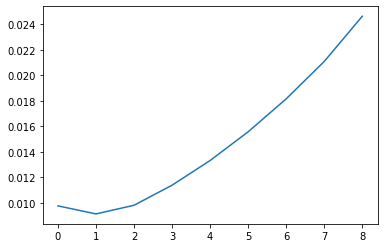

In [30]:
plt.plot(averaged.mean(0))

tensor([6.])


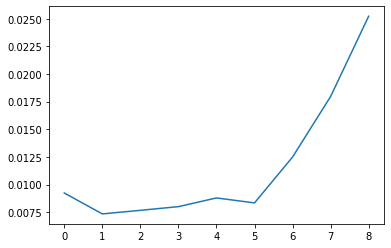

In [31]:
i = 0
plt.plot(averaged[i])
print(np.floor((targs[i]-volume.get_passive_z_range()[0]-(2*volume.passive_size))/volume.passive_size))

tensor([7.])


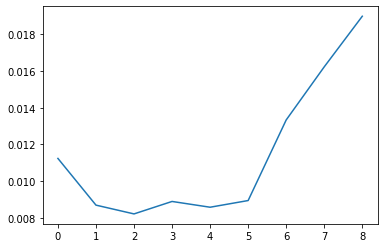

In [32]:
i = 1
plt.plot(averaged[i])
print(np.floor((targs[i]-volume.get_passive_z_range()[0]-(2*volume.passive_size))/volume.passive_size))

tensor([1.])


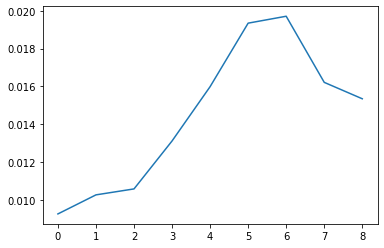

In [33]:
i = 3
plt.plot(averaged[i])
print(np.floor((targs[i]-volume.get_passive_z_range()[0]-(2*volume.passive_size))/volume.passive_size))

In [34]:
averaged.shape

torch.Size([200, 9])

In [37]:
mcorr = pgen.x0_furnace/preds[:,0].mean(); mcorr

tensor(1.5081)

In [38]:
pgen.x0_furnace,preds[:,0].mean()

(0.01757, tensor(0.0117))

In [39]:
ladel_removed.mean((0,2,3))

tensor([0.0098, 0.0091, 0.0098, 0.0114, 0.0133, 0.0156, 0.0182, 0.0211, 0.0246])

In [40]:
ladel_removed.mean((0,2,3))*mcorr

tensor([0.0147, 0.0138, 0.0148, 0.0172, 0.0201, 0.0235, 0.0274, 0.0318, 0.0372])

In [41]:
acorr = pgen.x0_furnace-preds[:,0].mean(); acorr

tensor(0.0059)

In [42]:
pgen.x0_furnace,preds[:,0].mean()

(0.01757, tensor(0.0117))

In [43]:
ladel_removed.mean((0,2,3))

tensor([0.0098, 0.0091, 0.0098, 0.0114, 0.0133, 0.0156, 0.0182, 0.0211, 0.0246])

In [44]:
ladel_removed.mean((0,2,3))+acorr

tensor([0.0157, 0.0150, 0.0157, 0.0173, 0.0192, 0.0215, 0.0241, 0.0270, 0.0306])

tensor([7.])


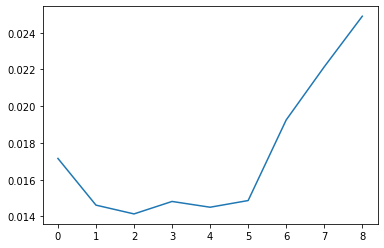

In [45]:
i = 1
plt.plot(averaged[i]+acorr)
print(np.floor((targs[i]-volume.get_passive_z_range()[0]-(2*volume.passive_size))/volume.passive_size))

## Classification

In [46]:
averaged.shape

torch.Size([200, 9])

In [47]:
pgen.fill_z_range

(0.3000000178813934, 1.2000000476837158)

In [48]:
n = len(volume.get_passives())

In [49]:
hypotheses = torch.stack([(X0['air']*(n-i))/(pgen.fill_x0s.mean()*i) for i in range(2,n-1)], dim=0)

In [50]:
hypotheses

tensor([14037.0918,  8188.3037,  5263.9092,  3509.2725,  2339.5151,  1503.9740,
          877.3182])

In [51]:
hypotheses.shape

torch.Size([7])

In [52]:
averaged.shape

torch.Size([200, 9])

In [53]:
averaged[:,8:].sum(-1)

tensor([0.0252, 0.0190, 0.0202, 0.0153, 0.0257, 0.0263, 0.0203, 0.0199, 0.0209,
        0.0251, 0.0334, 0.0259, 0.0308, 0.0295, 0.0276, 0.0210, 0.0172, 0.0250,
        0.0301, 0.0181, 0.0197, 0.0241, 0.0301, 0.0314, 0.0216, 0.0241, 0.0236,
        0.0301, 0.0185, 0.0348, 0.0269, 0.0225, 0.0245, 0.0274, 0.0277, 0.0236,
        0.0208, 0.0242, 0.0262, 0.0204, 0.0224, 0.0201, 0.0313, 0.0235, 0.0279,
        0.0264, 0.0210, 0.0199, 0.0207, 0.0317, 0.0302, 0.0276, 0.0266, 0.0272,
        0.0199, 0.0246, 0.0323, 0.0205, 0.0189, 0.0380, 0.0226, 0.0213, 0.0230,
        0.0229, 0.0254, 0.0192, 0.0287, 0.0270, 0.0192, 0.0223, 0.0319, 0.0255,
        0.0222, 0.0167, 0.0260, 0.0241, 0.0260, 0.0230, 0.0325, 0.0234, 0.0336,
        0.0266, 0.0264, 0.0334, 0.0240, 0.0191, 0.0369, 0.0246, 0.0243, 0.0196,
        0.0238, 0.0261, 0.0291, 0.0168, 0.0174, 0.0209, 0.0240, 0.0147, 0.0291,
        0.0195, 0.0270, 0.0221, 0.0236, 0.0221, 0.0279, 0.0211, 0.0225, 0.0204,
        0.0362, 0.0191, 0.0181, 0.0277, 

## No bias correction

In [54]:
pred_ratio = torch.stack([averaged[:,i:].sum(-1)/averaged[:,:i].sum(-1) for i in range(2,n-1)], dim=1)

In [55]:
pred_ratio

tensor([[5.3359, 3.3319, 2.2568,  ..., 1.1271, 0.6978, 0.3158],
        [4.1721, 2.6622, 1.7828,  ..., 0.8890, 0.5182, 0.2255],
        [6.4058, 3.8941, 2.6036,  ..., 1.1248, 0.5906, 0.2442],
        ...,
        [6.0298, 3.6432, 2.3316,  ..., 1.0110, 0.6364, 0.2997],
        [4.2869, 2.7809, 2.0097,  ..., 1.0303, 0.6469, 0.3044],
        [7.3673, 3.8220, 2.3229,  ..., 0.7724, 0.3846, 0.1656]])

In [56]:
pred_ratio.shape

torch.Size([200, 7])

In [79]:
logits = 1/torch.abs((hypotheses/pred_ratio)-1)

In [80]:
logits

tensor([[0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0005, 0.0004],
        [0.0003, 0.0003, 0.0003,  ..., 0.0004, 0.0003, 0.0003],
        [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0004, 0.0003],
        ...,
        [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0003],
        [0.0003, 0.0003, 0.0004,  ..., 0.0004, 0.0004, 0.0003],
        [0.0005, 0.0005, 0.0004,  ..., 0.0003, 0.0003, 0.0002]])

In [81]:
hypotheses

tensor([14037.0918,  8188.3037,  5263.9092,  3509.2725,  2339.5151,  1503.9740,
          877.3182])

In [82]:
probs = F.softmax(logits, dim=-1)

In [83]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [84]:
p

tensor([0.8000, 0.8000, 0.7000, 0.5000, 0.8000, 0.5000, 0.5000, 0.5000, 0.8000,
        0.5000, 0.6000, 0.5000, 0.6000, 0.4000, 0.4000, 0.5000, 0.7000, 0.6000,
        0.5000, 0.6000, 0.6000, 0.4000, 0.4000, 0.5000, 0.8000, 0.8000, 0.4000,
        0.8000, 0.4000, 0.8000, 0.6000, 0.6000, 0.7000, 0.5000, 0.8000, 0.5000,
        0.8000, 0.7000, 0.7000, 0.8000, 0.6000, 0.7000, 0.5000, 0.7000, 0.5000,
        0.7000, 0.5000, 0.4000, 0.4000, 0.8000, 0.5000, 0.4000, 0.4000, 0.5000,
        0.5000, 0.7000, 0.6000, 0.5000, 0.4000, 0.7000, 0.8000, 0.8000, 0.8000,
        0.7000, 0.6000, 0.4000, 0.4000, 0.6000, 0.5000, 0.4000, 0.7000, 0.5000,
        0.7000, 0.7000, 0.6000, 0.6000, 0.4000, 0.4000, 0.8000, 0.4000, 0.7000,
        0.8000, 0.6000, 0.5000, 0.7000, 0.6000, 0.8000, 0.5000, 0.5000, 0.6000,
        0.6000, 0.5000, 0.4000, 0.4000, 0.8000, 0.4000, 0.5000, 0.4000, 0.4000,
        0.5000, 0.7000, 0.6000, 0.5000, 0.8000, 0.8000, 0.4000, 0.4000, 0.6000,
        0.6000, 0.7000, 0.6000, 0.7000, 

In [85]:
probs.argmax(-1)

tensor([4, 4, 3, 1, 4, 1, 1, 1, 4, 1, 2, 1, 2, 0, 0, 1, 3, 2, 1, 2, 2, 0, 0, 1,
        4, 4, 0, 4, 0, 4, 2, 2, 3, 1, 4, 1, 4, 3, 3, 4, 2, 3, 1, 3, 1, 3, 1, 0,
        0, 4, 1, 0, 0, 1, 1, 3, 2, 1, 0, 3, 4, 4, 4, 3, 2, 0, 0, 2, 1, 0, 3, 1,
        3, 3, 2, 2, 0, 0, 4, 0, 3, 4, 2, 1, 3, 2, 4, 1, 1, 2, 2, 1, 0, 0, 4, 0,
        1, 0, 0, 1, 3, 2, 1, 4, 4, 0, 0, 2, 2, 3, 2, 3, 0, 2, 2, 4, 0, 1, 2, 2,
        1, 2, 0, 1, 0, 0, 2, 2, 3, 0, 3, 4, 0, 0, 1, 2, 3, 4, 2, 1, 0, 1, 0, 4,
        1, 1, 4, 1, 2, 3, 1, 0, 3, 0, 2, 1, 0, 1, 1, 0, 3, 3, 0, 0, 0, 1, 1, 1,
        0, 3, 4, 4, 1, 0, 3, 4, 3, 2, 1, 1, 2, 0, 3, 2, 2, 0, 0, 0, 3, 0, 0, 1,
        3, 4, 1, 0, 4, 1, 4, 0])

In [86]:
volume.get_passive_z_range()

(tensor([0.2000]), tensor([1.2000]))

In [87]:
get_mse(p, targs)

tensor(0.1199)

## Multiplicative bias correction
Assume layer 1 is filled
Assume layer -1 is air

In [88]:
fill_bias = averaged[:,0]/pgen.fill_x0s.mean()

In [89]:
air_bias = averaged[:,-1]/X0['air']

In [90]:
pgen.fill_x0s.mean(), averaged[:,0].mean(), (averaged[:,0]/fill_bias).mean()

(tensor(0.0890), tensor(0.0098), tensor(0.0890))

In [91]:
pred_ratio = torch.stack([(averaged[:,i:].sum(-1)/air_bias)/(averaged[:,:i].sum(-1)/fill_bias) for i in range(2,n-1)], dim=1)

In [92]:
pred_ratio.shape

torch.Size([200, 7])

In [93]:
logits =  1/torch.abs((hypotheses/pred_ratio)-1)

In [94]:
probs = F.softmax(logits, dim=-1)

In [95]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [96]:
p

tensor([0.8000, 0.8000, 0.7000, 0.5000, 0.8000, 0.5000, 0.5000, 0.5000, 0.8000,
        0.5000, 0.6000, 0.5000, 0.6000, 0.4000, 0.4000, 0.5000, 0.7000, 0.6000,
        0.5000, 0.6000, 0.6000, 0.4000, 0.4000, 0.5000, 0.8000, 0.8000, 0.4000,
        0.8000, 0.4000, 0.8000, 0.6000, 0.6000, 0.7000, 0.5000, 0.8000, 0.5000,
        0.8000, 0.7000, 0.7000, 0.8000, 0.6000, 0.7000, 0.5000, 0.7000, 0.5000,
        0.7000, 0.5000, 0.4000, 0.4000, 0.8000, 0.5000, 0.4000, 0.4000, 0.5000,
        0.5000, 0.7000, 0.6000, 0.5000, 0.4000, 0.7000, 0.8000, 0.8000, 0.8000,
        0.7000, 0.6000, 0.4000, 0.4000, 0.6000, 0.5000, 0.4000, 0.7000, 0.5000,
        0.7000, 0.7000, 0.6000, 0.6000, 0.4000, 0.4000, 0.8000, 0.4000, 0.7000,
        0.8000, 0.6000, 0.5000, 0.7000, 0.6000, 0.8000, 0.5000, 0.5000, 0.6000,
        0.6000, 0.5000, 0.4000, 0.4000, 0.8000, 0.4000, 0.5000, 0.4000, 0.4000,
        0.5000, 0.7000, 0.6000, 0.5000, 0.8000, 0.8000, 0.4000, 0.4000, 0.6000,
        0.6000, 0.7000, 0.6000, 0.7000, 

In [97]:
probs.argmax(-1)

tensor([4, 4, 3, 1, 4, 1, 1, 1, 4, 1, 2, 1, 2, 0, 0, 1, 3, 2, 1, 2, 2, 0, 0, 1,
        4, 4, 0, 4, 0, 4, 2, 2, 3, 1, 4, 1, 4, 3, 3, 4, 2, 3, 1, 3, 1, 3, 1, 0,
        0, 4, 1, 0, 0, 1, 1, 3, 2, 1, 0, 3, 4, 4, 4, 3, 2, 0, 0, 2, 1, 0, 3, 1,
        3, 3, 2, 2, 0, 0, 4, 0, 3, 4, 2, 1, 3, 2, 4, 1, 1, 2, 2, 1, 0, 0, 4, 0,
        1, 0, 0, 1, 3, 2, 1, 4, 4, 0, 0, 2, 2, 3, 2, 3, 0, 2, 2, 4, 0, 1, 2, 2,
        1, 2, 0, 1, 0, 0, 2, 2, 3, 0, 3, 4, 0, 0, 1, 2, 3, 4, 2, 1, 0, 1, 0, 4,
        1, 1, 4, 1, 2, 3, 1, 0, 3, 1, 2, 1, 0, 1, 1, 0, 3, 3, 0, 0, 0, 1, 1, 1,
        0, 3, 4, 4, 1, 0, 3, 4, 3, 2, 1, 1, 2, 0, 3, 2, 2, 0, 0, 0, 3, 0, 0, 1,
        3, 4, 1, 0, 4, 1, 4, 0])

In [99]:
get_mse(p, targs)

tensor(0.1196)

# Edge finding

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


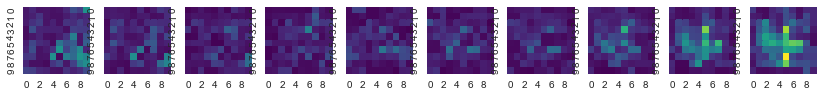

In [160]:
plot_pred(preds[0], targs[0])

In [161]:
preds[0].shape

torch.Size([10, 10, 10])

In [162]:
averaged[0,:,None,None].shape

torch.Size([9, 1, 1])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


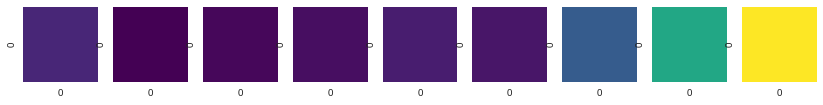

In [163]:
plot_pred(averaged[0,:,None,None], targs[0])

## Difference

In [164]:
averaged[0]

tensor([0.0092, 0.0073, 0.0077, 0.0080, 0.0088, 0.0083, 0.0125, 0.0180, 0.0252])

In [165]:
maxes = F.max_pool1d(averaged, kernel_size=3, padding=1, stride=1)

In [166]:
maxes.shape

torch.Size([200, 9])

In [167]:
maxes

tensor([[0.0092, 0.0092, 0.0080,  ..., 0.0180, 0.0252, 0.0252],
        [0.0112, 0.0112, 0.0089,  ..., 0.0162, 0.0190, 0.0190],
        [0.0077, 0.0077, 0.0075,  ..., 0.0180, 0.0202, 0.0202],
        ...,
        [0.0103, 0.0103, 0.0116,  ..., 0.0216, 0.0315, 0.0315],
        [0.0123, 0.0123, 0.0094,  ..., 0.0183, 0.0268, 0.0268],
        [0.0089, 0.0121, 0.0129,  ..., 0.0217, 0.0217, 0.0195]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


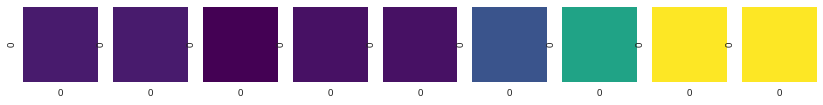

In [168]:
plot_pred(maxes[0,:,None,None], targs[0])

In [145]:
mins = -F.max_pool1d(-averaged, kernel_size=3, padding=1, stride=1)

In [146]:
mins

tensor([[0.0073, 0.0073, 0.0073,  ..., 0.0083, 0.0125, 0.0180],
        [0.0087, 0.0082, 0.0082,  ..., 0.0089, 0.0133, 0.0162],
        [0.0062, 0.0062, 0.0062,  ..., 0.0116, 0.0162, 0.0180],
        ...,
        [0.0091, 0.0091, 0.0091,  ..., 0.0129, 0.0156, 0.0216],
        [0.0094, 0.0086, 0.0078,  ..., 0.0110, 0.0131, 0.0183],
        [0.0075, 0.0075, 0.0089,  ..., 0.0187, 0.0187, 0.0187]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


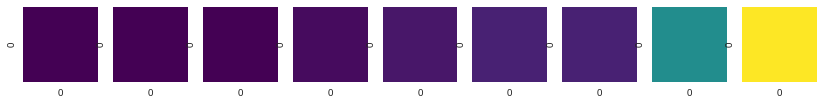

In [169]:
plot_pred(mins[0,:,None,None], targs[0])

In [186]:
diffs = maxes-mins

In [187]:
diffs

tensor([[0.0019, 0.0019, 0.0007,  ..., 0.0096, 0.0127, 0.0073],
        [0.0025, 0.0030, 0.0007,  ..., 0.0073, 0.0056, 0.0028],
        [0.0015, 0.0015, 0.0013,  ..., 0.0064, 0.0039, 0.0022],
        ...,
        [0.0012, 0.0012, 0.0025,  ..., 0.0087, 0.0160, 0.0099],
        [0.0028, 0.0036, 0.0017,  ..., 0.0073, 0.0136, 0.0085],
        [0.0014, 0.0045, 0.0040,  ..., 0.0031, 0.0031, 0.0009]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


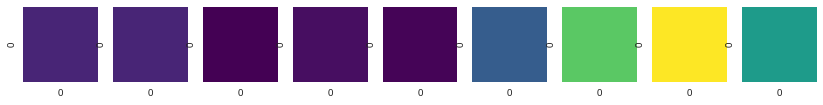

In [188]:
plot_pred(diffs[0,:,None,None], targs[0])

In [189]:
probs = F.softmax(diffs, dim=-1)

In [190]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [191]:
probs.argmax(-1)

tensor([7, 6, 5, 4, 6, 6, 4, 5, 6, 6, 5, 4, 4, 7, 5, 5, 7, 6, 7, 7, 3, 4, 7, 3,
        6, 7, 7, 6, 4, 6, 5, 4, 5, 7, 7, 7, 6, 6, 5, 7, 7, 6, 7, 7, 5, 6, 4, 5,
        5, 6, 5, 5, 7, 5, 3, 7, 5, 7, 2, 6, 6, 7, 7, 5, 5, 4, 1, 7, 7, 2, 7, 3,
        7, 5, 7, 7, 6, 2, 7, 7, 5, 7, 7, 7, 5, 5, 7, 7, 3, 6, 7, 7, 7, 3, 6, 4,
        4, 2, 3, 3, 5, 4, 7, 6, 7, 2, 7, 7, 5, 5, 6, 7, 3, 5, 4, 6, 7, 5, 5, 6,
        5, 7, 1, 4, 7, 2, 4, 7, 7, 6, 6, 6, 5, 6, 6, 7, 7, 7, 7, 4, 4, 4, 7, 7,
        6, 6, 6, 6, 4, 6, 6, 3, 7, 3, 4, 4, 7, 3, 5, 5, 5, 5, 7, 7, 5, 3, 7, 2,
        7, 7, 7, 6, 7, 7, 7, 7, 6, 6, 7, 3, 5, 4, 5, 7, 6, 3, 3, 5, 6, 4, 2, 7,
        7, 7, 7, 4, 7, 7, 7, 4])

In [192]:
get_mse(p, targs)

tensor(0.1305)

In [173]:
diffs = maxes/mins

In [174]:
diffs

tensor([[1.2571, 1.2571, 1.0897,  ..., 2.1533, 2.0190, 1.4039],
        [1.2921, 1.3673, 1.0825,  ..., 1.8130, 1.4232, 1.1697],
        [1.2345, 1.2345, 1.2109,  ..., 1.5535, 1.2417, 1.1215],
        ...,
        [1.1318, 1.1318, 1.2707,  ..., 1.6710, 2.0255, 1.4567],
        [1.3016, 1.4197, 1.2125,  ..., 1.6618, 2.0352, 1.4631],
        [1.1805, 1.6032, 1.4461,  ..., 1.1645, 1.1645, 1.0469]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([2.])


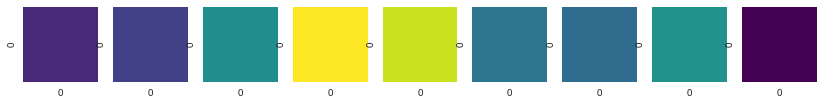

In [180]:
plot_pred(diffs[3,:,None,None], targs[3])

In [181]:
probs = F.softmax(diffs, dim=-1)

In [182]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [184]:
probs.argmax(-1)

tensor([6, 6, 5, 3, 6, 3, 4, 5, 6, 6, 5, 3, 3, 6, 5, 4, 1, 4, 4, 7, 3, 4, 2, 3,
        6, 5, 1, 6, 4, 6, 4, 4, 5, 2, 6, 3, 5, 4, 4, 7, 4, 5, 3, 5, 5, 5, 4, 5,
        2, 5, 3, 5, 7, 5, 3, 7, 5, 3, 2, 5, 6, 6, 7, 5, 4, 4, 1, 4, 3, 2, 5, 2,
        7, 5, 7, 3, 6, 2, 6, 1, 5, 7, 4, 6, 5, 5, 6, 3, 3, 5, 3, 3, 2, 3, 1, 4,
        4, 2, 3, 3, 5, 4, 7, 6, 7, 2, 7, 4, 4, 5, 6, 7, 2, 5, 4, 6, 7, 5, 4, 1,
        5, 4, 1, 3, 2, 2, 4, 4, 4, 6, 6, 6, 2, 5, 2, 7, 7, 7, 6, 3, 4, 4, 6, 6,
        6, 5, 6, 3, 4, 6, 3, 2, 5, 3, 4, 3, 2, 3, 2, 4, 5, 4, 2, 7, 5, 3, 6, 2,
        3, 7, 6, 5, 3, 2, 5, 6, 5, 6, 7, 3, 5, 4, 5, 4, 6, 2, 3, 5, 5, 1, 2, 7,
        1, 6, 7, 4, 7, 7, 7, 1])

In [185]:
get_mse(p, targs)

tensor(0.1043)

## Pre-Blurring

In [164]:
averaged[0]

tensor([0.0092, 0.0073, 0.0077, 0.0080, 0.0088, 0.0083, 0.0125, 0.0180, 0.0252])

In [200]:
blurred = F.avg_pool1d(averaged, kernel_size=3, padding=1, stride=1, count_include_pad=False)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


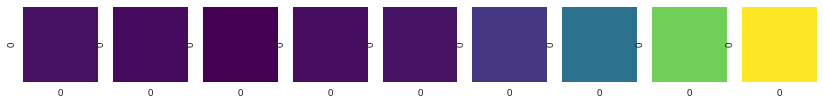

In [201]:
plot_pred(blurred[0,:,None,None], targs[0])

In [219]:
maxes = F.max_pool1d(blurred, kernel_size=3, padding=1, stride=1)

In [220]:
maxes.shape

torch.Size([200, 9])

In [221]:
maxes

tensor([[0.0083, 0.0083, 0.0082,  ..., 0.0186, 0.0216, 0.0216],
        [0.0100, 0.0100, 0.0094,  ..., 0.0162, 0.0176, 0.0176],
        [0.0070, 0.0070, 0.0076,  ..., 0.0181, 0.0191, 0.0191],
        ...,
        [0.0098, 0.0102, 0.0119,  ..., 0.0229, 0.0266, 0.0266],
        [0.0108, 0.0108, 0.0101,  ..., 0.0194, 0.0225, 0.0225],
        [0.0095, 0.0113, 0.0135,  ..., 0.0203, 0.0203, 0.0200]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


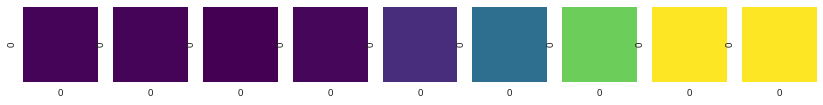

In [222]:
plot_pred(maxes[0,:,None,None], targs[0])

In [223]:
mins = -F.max_pool1d(-blurred, kernel_size=3, padding=1, stride=1)

In [224]:
mins

tensor([[0.0081, 0.0077, 0.0077,  ..., 0.0099, 0.0129, 0.0186],
        [0.0094, 0.0086, 0.0086,  ..., 0.0103, 0.0128, 0.0162],
        [0.0069, 0.0069, 0.0069,  ..., 0.0120, 0.0153, 0.0181],
        ...,
        [0.0097, 0.0097, 0.0098,  ..., 0.0142, 0.0167, 0.0229],
        [0.0101, 0.0086, 0.0079,  ..., 0.0105, 0.0141, 0.0194],
        [0.0082, 0.0082, 0.0095,  ..., 0.0193, 0.0191, 0.0191]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


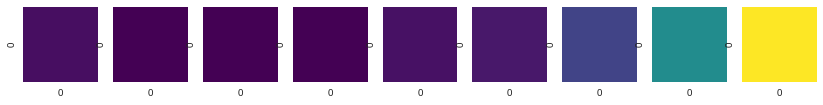

In [225]:
plot_pred(mins[0,:,None,None], targs[0])

In [226]:
diffs = maxes-mins

In [227]:
diffs

tensor([[2.0655e-04, 6.1656e-04, 4.8142e-04,  ..., 8.6841e-03, 8.6601e-03,
         3.0339e-03],
        [5.8286e-04, 1.3632e-03, 8.1836e-04,  ..., 5.8888e-03, 4.7646e-03,
         1.4221e-03],
        [6.0972e-05, 6.0972e-05, 6.8628e-04,  ..., 6.0976e-03, 3.8057e-03,
         9.4350e-04],
        ...,
        [9.0623e-05, 5.1289e-04, 2.0454e-03,  ..., 8.7360e-03, 9.8595e-03,
         3.6711e-03],
        [7.3508e-04, 2.2334e-03, 2.1815e-03,  ..., 8.8895e-03, 8.3767e-03,
         3.1254e-03],
        [1.2894e-03, 3.0666e-03, 4.0347e-03,  ..., 9.9882e-04, 1.2107e-03,
         8.7801e-04]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


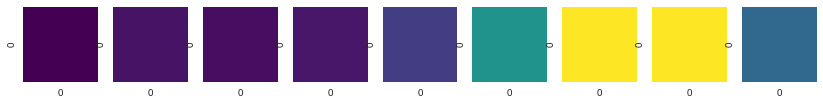

In [228]:
plot_pred(diffs[0,:,None,None], targs[0])

In [229]:
probs = F.softmax(diffs, dim=-1)

In [230]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [231]:
probs.argmax(-1)

tensor([6, 6, 5, 4, 6, 5, 4, 5, 6, 6, 5, 3, 3, 6, 5, 4, 6, 5, 6, 7, 3, 3, 7, 3,
        6, 6, 7, 6, 4, 6, 5, 5, 6, 6, 6, 4, 6, 6, 5, 6, 6, 6, 4, 6, 5, 6, 4, 5,
        4, 6, 4, 5, 6, 4, 3, 6, 5, 4, 3, 6, 6, 6, 7, 6, 5, 3, 5, 6, 4, 2, 6, 3,
        6, 4, 6, 6, 6, 2, 6, 2, 6, 6, 6, 6, 5, 5, 6, 6, 3, 6, 4, 3, 2, 3, 6, 3,
        3, 2, 3, 2, 6, 4, 7, 6, 7, 3, 7, 6, 6, 6, 5, 6, 3, 5, 4, 6, 6, 5, 6, 6,
        5, 6, 2, 4, 7, 2, 4, 6, 6, 6, 6, 6, 4, 6, 6, 7, 7, 6, 6, 4, 4, 4, 6, 6,
        6, 6, 6, 6, 4, 6, 5, 3, 6, 2, 4, 4, 6, 3, 4, 5, 5, 5, 6, 6, 4, 3, 7, 2,
        3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 6, 6, 6, 3, 3, 5, 6, 5, 2, 7,
        6, 6, 7, 4, 6, 7, 6, 4])

In [232]:
get_mse(p, targs)

tensor(0.1102)

In [233]:
diffs = maxes/mins

In [234]:
diffs

tensor([[1.0255, 1.0803, 1.0627,  ..., 1.8793, 1.6696, 1.1635],
        [1.0621, 1.1584, 1.0955,  ..., 1.5724, 1.3712, 1.0879],
        [1.0088, 1.0088, 1.0988,  ..., 1.5073, 1.2495, 1.0521],
        ...,
        [1.0093, 1.0528, 1.2085,  ..., 1.6168, 1.5900, 1.1603],
        [1.0727, 1.2593, 1.2751,  ..., 1.8458, 1.5921, 1.1611],
        [1.1568, 1.3730, 1.4242,  ..., 1.0517, 1.0634, 1.0459]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


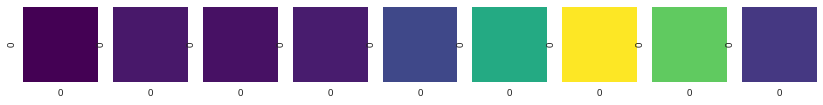

In [240]:
plot_pred(diffs[0,:,None,None], targs[0])

In [236]:
probs = F.softmax(diffs, dim=-1)

In [237]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [238]:
probs.argmax(-1)

tensor([6, 6, 5, 3, 6, 3, 3, 5, 6, 5, 5, 3, 3, 6, 4, 4, 6, 4, 3, 7, 3, 3, 2, 3,
        6, 6, 6, 5, 4, 6, 4, 4, 4, 6, 6, 3, 6, 5, 4, 6, 4, 5, 3, 6, 4, 5, 4, 5,
        4, 5, 4, 5, 3, 4, 3, 6, 5, 3, 3, 5, 6, 6, 6, 5, 4, 3, 1, 5, 4, 1, 6, 3,
        6, 4, 6, 3, 6, 2, 6, 2, 4, 6, 4, 6, 5, 5, 6, 6, 3, 4, 3, 3, 2, 3, 6, 3,
        3, 2, 2, 2, 5, 4, 7, 6, 6, 2, 7, 4, 4, 6, 5, 6, 2, 5, 4, 5, 6, 4, 4, 6,
        4, 4, 2, 4, 2, 2, 4, 4, 6, 6, 5, 6, 4, 5, 3, 3, 6, 6, 6, 3, 3, 3, 6, 6,
        6, 5, 5, 3, 4, 6, 3, 2, 5, 2, 4, 3, 2, 3, 3, 4, 5, 4, 6, 6, 4, 2, 6, 2,
        3, 6, 6, 5, 3, 2, 6, 6, 5, 5, 3, 3, 4, 3, 5, 5, 5, 2, 2, 5, 5, 2, 2, 3,
        6, 6, 6, 3, 6, 6, 6, 3])

In [239]:
get_mse(p, targs)

tensor(0.0958)

## Ridge kernel

In [432]:
ridge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)

In [433]:
ridge.weight

Parameter containing:
tensor([[[-0.0329, -0.4223, -0.3990]]], requires_grad=True)

In [434]:
ridge.weight.data = Tensor([[[-1,1,-1]]])

In [435]:
ridge.requires_grad_(False)

Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=replicate)

In [436]:
ridged = ridge(averaged[:,None]).squeeze()

In [437]:
ridged.shape

torch.Size([200, 9])

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


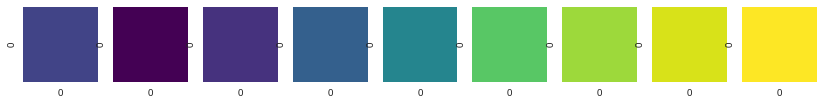

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


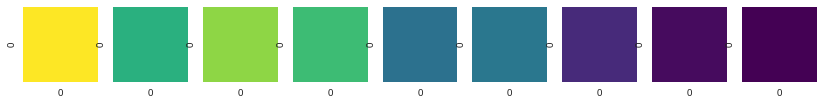

In [438]:
i=6
plot_pred(averaged[i,:,None,None], targs[i])
plot_pred(ridged[i,:,None,None], targs[i])

In [439]:
probs = F.softmax(ridged, dim=-1)

In [440]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [441]:
probs.argmax(-1)

tensor([0, 3, 0, 1, 3, 0, 0, 0, 3, 0, 2, 0, 1, 2, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0,
        3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 3, 2, 2, 1, 2, 1, 0, 0, 2,
        0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0,
        0, 0, 0, 1, 0, 2, 0, 3, 3, 0, 0, 4, 2, 2, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 2, 0, 1, 2, 0, 0, 3, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 1,
        1, 2, 3, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 3, 1, 0, 0, 1, 1, 2, 2, 1, 0,
        2, 0, 0, 0, 0, 0, 3, 0])

In [442]:
get_mse(p, targs)

tensor(0.1539)

### Minmax

In [443]:
maxes = F.max_pool1d(ridged, kernel_size=3, padding=1, stride=1)

In [444]:
maxes.shape

torch.Size([200, 9])

In [445]:
maxes

tensor([[-0.0073, -0.0073, -0.0077,  ..., -0.0129, -0.0138, -0.0180],
        [-0.0087, -0.0087, -0.0079,  ..., -0.0118, -0.0118, -0.0161],
        [-0.0062, -0.0062, -0.0066,  ..., -0.0129, -0.0133, -0.0180],
        ...,
        [-0.0091, -0.0091, -0.0107,  ..., -0.0166, -0.0190, -0.0216],
        [-0.0094, -0.0086, -0.0082,  ..., -0.0095, -0.0161, -0.0183],
        [-0.0089, -0.0089, -0.0097,  ..., -0.0169, -0.0175, -0.0187]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


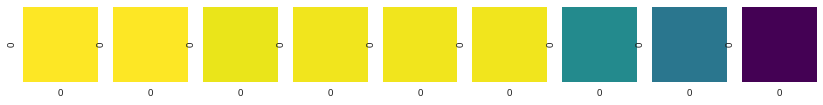

In [446]:
plot_pred(maxes[0,:,None,None], targs[0])

In [447]:
mins = -F.max_pool1d(-ridged, kernel_size=3, padding=1, stride=1)

In [448]:
mins

tensor([[-0.0096, -0.0096, -0.0096,  ..., -0.0197, -0.0197, -0.0197],
        [-0.0108, -0.0108, -0.0108,  ..., -0.0161, -0.0162, -0.0162],
        [-0.0086, -0.0086, -0.0086,  ..., -0.0184, -0.0184, -0.0184],
        ...,
        [-0.0112, -0.0112, -0.0124,  ..., -0.0254, -0.0254, -0.0254],
        [-0.0115, -0.0115, -0.0115,  ..., -0.0216, -0.0216, -0.0216],
        [-0.0107, -0.0107, -0.0149,  ..., -0.0226, -0.0226, -0.0226]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


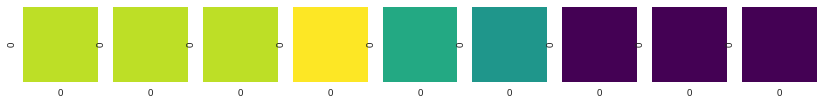

In [449]:
plot_pred(mins[0,:,None,None], targs[0])

In [450]:
diffs = maxes-mins

In [451]:
diffs

tensor([[0.0022, 0.0022, 0.0019,  ..., 0.0068, 0.0059, 0.0018],
        [0.0021, 0.0021, 0.0029,  ..., 0.0042, 0.0044, 0.0001],
        [0.0024, 0.0024, 0.0020,  ..., 0.0055, 0.0051, 0.0004],
        ...,
        [0.0021, 0.0021, 0.0017,  ..., 0.0088, 0.0064, 0.0038],
        [0.0021, 0.0029, 0.0032,  ..., 0.0121, 0.0055, 0.0033],
        [0.0018, 0.0018, 0.0052,  ..., 0.0057, 0.0051, 0.0039]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


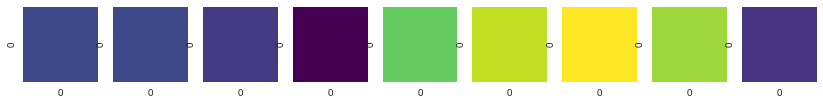

In [452]:
plot_pred(diffs[0,:,None,None], targs[0])

In [453]:
probs = F.softmax(diffs, dim=-1)

In [454]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [455]:
probs.argmax(-1)

tensor([6, 4, 6, 2, 4, 4, 3, 4, 4, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 3, 5, 5, 5,
        4, 6, 6, 5, 3, 4, 6, 6, 6, 4, 5, 6, 6, 5, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6,
        6, 7, 6, 3, 6, 3, 5, 6, 4, 5, 3, 4, 4, 5, 5, 6, 6, 6, 3, 5, 6, 3, 6, 4,
        6, 6, 5, 5, 5, 1, 6, 2, 6, 6, 6, 4, 4, 6, 5, 5, 4, 4, 6, 5, 5, 2, 4, 6,
        6, 1, 5, 4, 6, 2, 5, 4, 6, 6, 5, 5, 6, 6, 4, 6, 4, 6, 6, 5, 6, 4, 6, 5,
        6, 5, 3, 6, 4, 7, 6, 6, 6, 4, 4, 5, 4, 4, 4, 6, 6, 6, 5, 6, 3, 6, 6, 6,
        4, 4, 5, 5, 5, 5, 5, 5, 6, 1, 6, 6, 5, 5, 4, 6, 6, 6, 4, 6, 3, 4, 5, 1,
        6, 6, 6, 4, 6, 4, 6, 5, 6, 5, 6, 2, 6, 5, 3, 5, 5, 4, 2, 1, 6, 2, 4, 6,
        6, 6, 6, 5, 5, 6, 6, 3])

In [456]:
get_mse(p, targs)

tensor(0.1045)

In [457]:
diffs = maxes/mins

In [458]:
diffs

tensor([[0.7685, 0.7685, 0.8034,  ..., 0.6553, 0.6997, 0.9097],
        [0.8083, 0.8083, 0.7347,  ..., 0.7359, 0.7297, 0.9915],
        [0.7240, 0.7240, 0.7704,  ..., 0.7020, 0.7225, 0.9758],
        ...,
        [0.8147, 0.8147, 0.8646,  ..., 0.6526, 0.7477, 0.8504],
        [0.8207, 0.7451, 0.7178,  ..., 0.4402, 0.7469, 0.8460],
        [0.8297, 0.8297, 0.6504,  ..., 0.7460, 0.7725, 0.8255]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


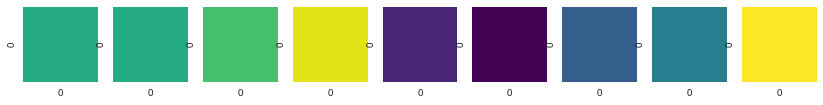

In [459]:
plot_pred(diffs[0,:,None,None], targs[0])

In [460]:
probs = F.softmax(diffs, dim=-1)

In [461]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [462]:
probs.argmax(-1)

tensor([8, 8, 8, 5, 0, 2, 8, 8, 8, 2, 8, 0, 4, 8, 8, 0, 0, 0, 0, 0, 0, 8, 7, 8,
        8, 8, 8, 0, 8, 2, 8, 8, 0, 8, 8, 0, 8, 8, 8, 0, 8, 0, 0, 8, 0, 8, 0, 8,
        0, 8, 0, 8, 4, 2, 8, 4, 0, 0, 7, 0, 3, 8, 8, 0, 8, 0, 8, 0, 0, 8, 8, 8,
        0, 0, 7, 8, 8, 3, 8, 8, 0, 0, 0, 0, 8, 8, 0, 8, 8, 8, 8, 0, 7, 4, 6, 0,
        7, 8, 8, 8, 2, 8, 8, 8, 0, 4, 2, 0, 0, 8, 2, 5, 8, 8, 0, 3, 8, 8, 0, 3,
        8, 8, 4, 8, 6, 4, 2, 8, 8, 6, 8, 2, 8, 8, 6, 8, 2, 8, 2, 8, 5, 8, 0, 8,
        2, 2, 8, 2, 8, 0, 0, 7, 8, 8, 0, 8, 0, 8, 8, 0, 8, 8, 8, 3, 8, 8, 8, 0,
        0, 8, 8, 8, 0, 8, 2, 8, 8, 0, 2, 0, 0, 8, 8, 0, 8, 8, 8, 6, 8, 4, 0, 2,
        8, 8, 2, 8, 8, 2, 8, 5])

In [463]:
get_mse(p, targs)

tensor(0.2093)

## Ridged blur

In [464]:
blurred = F.avg_pool1d(averaged, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [465]:
ridge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)

In [466]:
ridge.weight

Parameter containing:
tensor([[[-0.3759,  0.3233, -0.4466]]], requires_grad=True)

In [467]:
ridge.weight.data = Tensor([[[-1,1,-1]]])

In [468]:
ridge.requires_grad_(False)

Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=replicate)

In [469]:
ridged = ridge(blurred[:,None]).squeeze()

In [470]:
ridged.shape

torch.Size([200, 9])

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


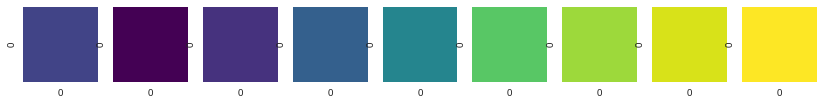

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


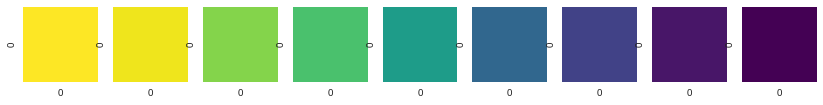

In [471]:
i=6
plot_pred(averaged[i,:,None,None], targs[i])
plot_pred(ridged[i,:,None,None], targs[i])

In [472]:
probs = F.softmax(ridged, dim=-1)

In [473]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [474]:
probs.argmax(-1)

tensor([1, 3, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 3, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 3, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0,
        0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0])

In [475]:
get_mse(p, targs)

tensor(0.1717)

### Minmax

In [476]:
maxes = F.max_pool1d(ridged, kernel_size=3, padding=1, stride=1)

In [477]:
maxes.shape

torch.Size([200, 9])

In [478]:
maxes

tensor([[-0.0079, -0.0079, -0.0079,  ..., -0.0114, -0.0155, -0.0160],
        [-0.0092, -0.0092, -0.0088,  ..., -0.0114, -0.0136, -0.0143],
        [-0.0069, -0.0069, -0.0069,  ..., -0.0124, -0.0149, -0.0162],
        ...,
        [-0.0098, -0.0098, -0.0101,  ..., -0.0154, -0.0204, -0.0204],
        [-0.0093, -0.0093, -0.0093,  ..., -0.0124, -0.0158, -0.0173],
        [-0.0095, -0.0095, -0.0100,  ..., -0.0174, -0.0190, -0.0194]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


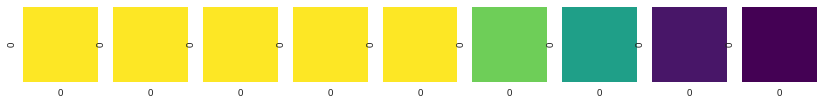

In [479]:
plot_pred(maxes[0,:,None,None], targs[0])

In [480]:
mins = -F.max_pool1d(-ridged, kernel_size=3, padding=1, stride=1)

In [481]:
mins

tensor([[-0.0081, -0.0086, -0.0086,  ..., -0.0160, -0.0186, -0.0186],
        [-0.0094, -0.0094, -0.0093,  ..., -0.0143, -0.0162, -0.0162],
        [-0.0070, -0.0077, -0.0084,  ..., -0.0162, -0.0181, -0.0181],
        ...,
        [-0.0101, -0.0114, -0.0114,  ..., -0.0204, -0.0229, -0.0229],
        [-0.0101, -0.0101, -0.0094,  ..., -0.0173, -0.0194, -0.0194],
        [-0.0100, -0.0118, -0.0141,  ..., -0.0194, -0.0200, -0.0200]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


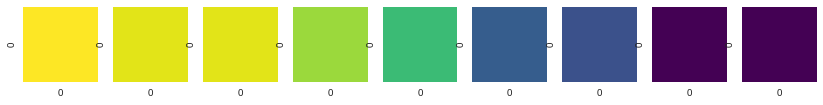

In [482]:
plot_pred(mins[0,:,None,None], targs[0])

In [483]:
diffs = maxes-mins

In [484]:
diffs

tensor([[2.0346e-04, 6.8488e-04, 6.8488e-04,  ..., 4.5290e-03, 3.0579e-03,
         2.5923e-03],
        [1.9747e-04, 1.9747e-04, 4.9971e-04,  ..., 2.9004e-03, 2.5462e-03,
         1.9205e-03],
        [1.0976e-04, 7.9604e-04, 1.5449e-03,  ..., 3.8494e-03, 3.2354e-03,
         1.9187e-03],
        ...,
        [3.3165e-04, 1.6232e-03, 1.2915e-03,  ..., 4.9945e-03, 2.5476e-03,
         2.5173e-03],
        [7.6320e-04, 7.6320e-04, 8.0001e-05,  ..., 4.9174e-03, 3.6382e-03,
         2.1258e-03],
        [4.8784e-04, 2.2575e-03, 4.1075e-03,  ..., 2.0786e-03, 9.9882e-04,
         5.4532e-04]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


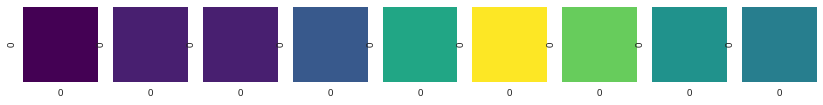

In [485]:
plot_pred(diffs[0,:,None,None], targs[0])

In [486]:
probs = F.softmax(diffs, dim=-1)

In [487]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [488]:
probs.argmax(-1)

tensor([5, 5, 5, 3, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 1, 5, 5, 5,
        5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 3, 5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 4, 3, 5, 5, 5, 5, 5, 5, 5, 2, 5, 2,
        2, 6, 4, 1, 5, 4, 5, 5, 5, 2, 5, 5, 5, 5, 4, 5, 3, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 2, 5, 5, 1, 5, 5, 5, 5, 5, 5, 3, 4, 4, 5, 5, 5, 5, 5, 3, 5, 5, 5,
        5, 4, 5, 5, 5, 5, 4, 4, 5, 1, 5, 5, 4, 5, 4, 3, 5, 5, 5, 5, 3, 4, 5, 3,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 4, 3, 6, 5, 4, 1, 5,
        5, 5, 5, 5, 5, 5, 5, 3])

In [489]:
get_mse(p, targs)

tensor(0.0885)

In [490]:
diffs = maxes/mins

In [491]:
diffs

tensor([[0.9748, 0.9201, 0.9201,  ..., 0.7164, 0.8352, 0.8603],
        [0.9790, 0.9790, 0.9465,  ..., 0.7966, 0.8426, 0.8813],
        [0.9843, 0.8963, 0.8167,  ..., 0.7624, 0.8214, 0.8941],
        ...,
        [0.9673, 0.8580, 0.8870,  ..., 0.7549, 0.8887, 0.8901],
        [0.9245, 0.9245, 0.9915,  ..., 0.7153, 0.8125, 0.8904],
        [0.9512, 0.8082, 0.7088,  ..., 0.8931, 0.9500, 0.9727]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


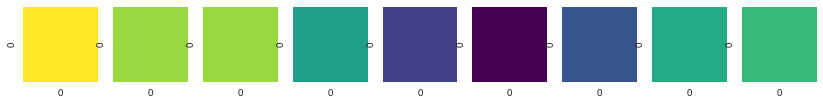

In [492]:
plot_pred(diffs[0,:,None,None], targs[0])

In [493]:
probs = F.softmax(diffs, dim=-1)

In [494]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [495]:
probs.argmax(-1)

tensor([0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 8, 8, 0, 0, 8, 0, 0, 8, 0, 0, 8, 8, 8,
        0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 8, 2, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0,
        8, 0, 0, 0, 0, 8, 7, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8,
        0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 8, 0, 0, 8, 8, 8, 0, 0,
        8, 8, 8, 2, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 6, 0, 6, 3, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 8, 0, 8, 0, 0,
        0, 0, 0, 8, 8, 0, 8, 8, 0, 4, 0, 8, 8, 7, 8, 0, 0, 0, 8, 0, 8, 8, 0, 8,
        8, 0, 0, 2, 8, 8, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0, 8, 7,
        2, 0, 0, 0, 0, 0, 2, 8])

In [496]:
get_mse(p, targs)

tensor(0.2080)

## Blurred ridge

In [502]:
ridge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)

In [503]:
ridge.weight

Parameter containing:
tensor([[[-0.5621,  0.3365, -0.3584]]], requires_grad=True)

In [504]:
ridge.weight.data = Tensor([[[-1,1,-1]]])

In [505]:
ridge.requires_grad_(False)

Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=replicate)

In [506]:
ridged = ridge(averaged[:,None]).squeeze()

In [507]:
blurred = F.avg_pool1d(ridged, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [508]:
ridged.shape

torch.Size([200, 9])

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


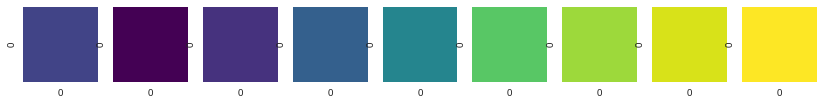

Zero-ordered target layer ID (including ladel bottom layer): tensor([0.])


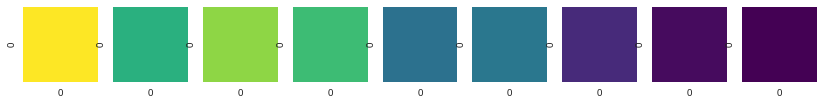

In [509]:
i=6
plot_pred(averaged[i,:,None,None], targs[i])
plot_pred(ridged[i,:,None,None], targs[i])

In [510]:
probs = F.softmax(ridged, dim=-1)

In [511]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [512]:
probs.argmax(-1)

tensor([0, 3, 0, 1, 3, 0, 0, 0, 3, 0, 2, 0, 1, 2, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0,
        3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 3, 2, 2, 1, 2, 1, 0, 0, 2,
        0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0,
        0, 0, 0, 1, 0, 2, 0, 3, 3, 0, 0, 4, 2, 2, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 2, 0, 1, 2, 0, 0, 3, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 1,
        1, 2, 3, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 3, 1, 0, 0, 1, 1, 2, 2, 1, 0,
        2, 0, 0, 0, 0, 0, 3, 0])

In [513]:
get_mse(p, targs)

tensor(0.1539)

### Minmax

In [514]:
maxes = F.max_pool1d(ridged, kernel_size=3, padding=1, stride=1)

In [515]:
maxes.shape

torch.Size([200, 9])

In [516]:
maxes

tensor([[-0.0073, -0.0073, -0.0077,  ..., -0.0129, -0.0138, -0.0180],
        [-0.0087, -0.0087, -0.0079,  ..., -0.0118, -0.0118, -0.0161],
        [-0.0062, -0.0062, -0.0066,  ..., -0.0129, -0.0133, -0.0180],
        ...,
        [-0.0091, -0.0091, -0.0107,  ..., -0.0166, -0.0190, -0.0216],
        [-0.0094, -0.0086, -0.0082,  ..., -0.0095, -0.0161, -0.0183],
        [-0.0089, -0.0089, -0.0097,  ..., -0.0169, -0.0175, -0.0187]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


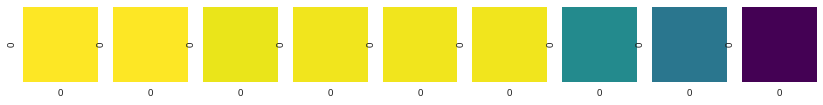

In [517]:
plot_pred(maxes[0,:,None,None], targs[0])

In [518]:
mins = -F.max_pool1d(-ridged, kernel_size=3, padding=1, stride=1)

In [519]:
mins

tensor([[-0.0096, -0.0096, -0.0096,  ..., -0.0197, -0.0197, -0.0197],
        [-0.0108, -0.0108, -0.0108,  ..., -0.0161, -0.0162, -0.0162],
        [-0.0086, -0.0086, -0.0086,  ..., -0.0184, -0.0184, -0.0184],
        ...,
        [-0.0112, -0.0112, -0.0124,  ..., -0.0254, -0.0254, -0.0254],
        [-0.0115, -0.0115, -0.0115,  ..., -0.0216, -0.0216, -0.0216],
        [-0.0107, -0.0107, -0.0149,  ..., -0.0226, -0.0226, -0.0226]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


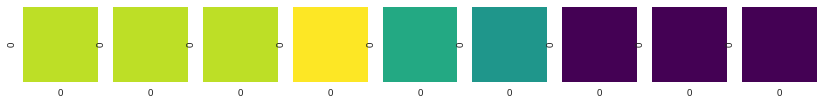

In [520]:
plot_pred(mins[0,:,None,None], targs[0])

In [521]:
diffs = maxes-mins

In [522]:
diffs

tensor([[0.0022, 0.0022, 0.0019,  ..., 0.0068, 0.0059, 0.0018],
        [0.0021, 0.0021, 0.0029,  ..., 0.0042, 0.0044, 0.0001],
        [0.0024, 0.0024, 0.0020,  ..., 0.0055, 0.0051, 0.0004],
        ...,
        [0.0021, 0.0021, 0.0017,  ..., 0.0088, 0.0064, 0.0038],
        [0.0021, 0.0029, 0.0032,  ..., 0.0121, 0.0055, 0.0033],
        [0.0018, 0.0018, 0.0052,  ..., 0.0057, 0.0051, 0.0039]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


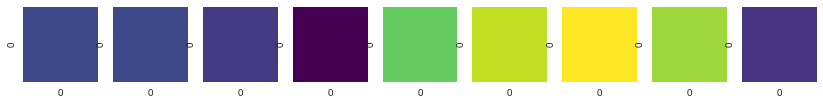

In [523]:
plot_pred(diffs[0,:,None,None], targs[0])

In [524]:
probs = F.softmax(diffs, dim=-1)

In [525]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [526]:
probs.argmax(-1)

tensor([6, 4, 6, 2, 4, 4, 3, 4, 4, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 5, 3, 5, 5, 5,
        4, 6, 6, 5, 3, 4, 6, 6, 6, 4, 5, 6, 6, 5, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6,
        6, 7, 6, 3, 6, 3, 5, 6, 4, 5, 3, 4, 4, 5, 5, 6, 6, 6, 3, 5, 6, 3, 6, 4,
        6, 6, 5, 5, 5, 1, 6, 2, 6, 6, 6, 4, 4, 6, 5, 5, 4, 4, 6, 5, 5, 2, 4, 6,
        6, 1, 5, 4, 6, 2, 5, 4, 6, 6, 5, 5, 6, 6, 4, 6, 4, 6, 6, 5, 6, 4, 6, 5,
        6, 5, 3, 6, 4, 7, 6, 6, 6, 4, 4, 5, 4, 4, 4, 6, 6, 6, 5, 6, 3, 6, 6, 6,
        4, 4, 5, 5, 5, 5, 5, 5, 6, 1, 6, 6, 5, 5, 4, 6, 6, 6, 4, 6, 3, 4, 5, 1,
        6, 6, 6, 4, 6, 4, 6, 5, 6, 5, 6, 2, 6, 5, 3, 5, 5, 4, 2, 1, 6, 2, 4, 6,
        6, 6, 6, 5, 5, 6, 6, 3])

In [527]:
get_mse(p, targs)

tensor(0.1045)

In [528]:
diffs = maxes/mins

In [529]:
diffs

tensor([[0.7685, 0.7685, 0.8034,  ..., 0.6553, 0.6997, 0.9097],
        [0.8083, 0.8083, 0.7347,  ..., 0.7359, 0.7297, 0.9915],
        [0.7240, 0.7240, 0.7704,  ..., 0.7020, 0.7225, 0.9758],
        ...,
        [0.8147, 0.8147, 0.8646,  ..., 0.6526, 0.7477, 0.8504],
        [0.8207, 0.7451, 0.7178,  ..., 0.4402, 0.7469, 0.8460],
        [0.8297, 0.8297, 0.6504,  ..., 0.7460, 0.7725, 0.8255]])

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


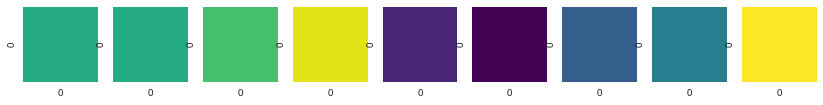

In [530]:
plot_pred(diffs[0,:,None,None], targs[0])

In [531]:
probs = F.softmax(diffs, dim=-1)

In [532]:
p = ((probs.argmax(-1)+2)*volume.passive_size)+volume.get_passive_z_range()[0]

In [533]:
probs.argmax(-1)

tensor([8, 8, 8, 5, 0, 2, 8, 8, 8, 2, 8, 0, 4, 8, 8, 0, 0, 0, 0, 0, 0, 8, 7, 8,
        8, 8, 8, 0, 8, 2, 8, 8, 0, 8, 8, 0, 8, 8, 8, 0, 8, 0, 0, 8, 0, 8, 0, 8,
        0, 8, 0, 8, 4, 2, 8, 4, 0, 0, 7, 0, 3, 8, 8, 0, 8, 0, 8, 0, 0, 8, 8, 8,
        0, 0, 7, 8, 8, 3, 8, 8, 0, 0, 0, 0, 8, 8, 0, 8, 8, 8, 8, 0, 7, 4, 6, 0,
        7, 8, 8, 8, 2, 8, 8, 8, 0, 4, 2, 0, 0, 8, 2, 5, 8, 8, 0, 3, 8, 8, 0, 3,
        8, 8, 4, 8, 6, 4, 2, 8, 8, 6, 8, 2, 8, 8, 6, 8, 2, 8, 2, 8, 5, 8, 0, 8,
        2, 2, 8, 2, 8, 0, 0, 7, 8, 8, 0, 8, 0, 8, 8, 0, 8, 8, 8, 3, 8, 8, 8, 0,
        0, 8, 8, 8, 0, 8, 2, 8, 8, 0, 2, 0, 0, 8, 8, 0, 8, 8, 8, 6, 8, 4, 0, 2,
        8, 8, 2, 8, 8, 2, 8, 5])

In [534]:
get_mse(p, targs)

tensor(0.2093)